In [0]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer,text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers
%matplotlib inline

In [0]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [0]:
MAX_SENT_LENGTH = 100
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [42]:
# reading data
df = pd.read_excel('dataset.xlsx')
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
print('No. of unique classes',len(set(df['class'])))

Shape of dataset  (100, 2)
Index(['message', 'class'], dtype='object')
No. of unique classes 17


In [0]:
import nltk
from nltk import tokenize

reviews = []
labels = []
texts = []

In [0]:
macronum=sorted(set(df['class']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

In [0]:
def fun(i):
    return macro_to_id[i]

df['class']=df['class'].apply(fun)

In [46]:
for i in range(df.message.shape[0]):
    text = BeautifulSoup(df.message[i])
    text=clean_str(str(text.get_text().encode()).lower())
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)


for i in df['class']:
    labels.append(i)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /usr/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTS, MAX_SENT_LENGTH), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j< MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                if k<MAX_SENT_LENGTH and tokenizer.word_index[word]<MAX_NB_WORDS:
                    data[i,j,k] = tokenizer.word_index[word]
                    k=k+1


In [48]:
word_index = tokenizer.word_index
print('No. of %s unique tokens.' % len(word_index))

No. of 932 unique tokens.


In [49]:
labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

Shape of data tensor: (100, 15, 100)
Shape of label tensor: (100, 17)


In [0]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [51]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [0]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,
                            trainable=True)

In [53]:
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
sentEncoder = Model(sentence_input, l_lstm)

review_input = Input(shape=(MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(LSTM(100))(review_encoder)
preds = Dense(len(macronum), activation='softmax')(l_lstm_sent)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Hierachical LSTM")
model.summary()

INFO (theano.gof.compilelock): Waiting for existing lock by process '1011' (I am process '1779')
INFO (theano.gof.compilelock): To manually release the lock, delete /content/.theano/compiledir_Linux-4.4.111+-x86_64-with-Ubuntu-17.10-artful-x86_64-3.6.3-64/lock_dir


Hierachical LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 200)           254100    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 17)                3417      
Total params: 498,317
Trainable params: 498,317
Non-trainable params: 0
_________________________________________________________________


In [54]:
cp=ModelCheckpoint('model_han_.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=15, batch_size=2,callbacks=[cp])

Train on 80 samples, validate on 20 samples
Epoch 1/15
80/80 [==============================] - 28s 351ms/step - loss: 2.5511 - acc: 0.1875 - val_loss: 2.9483 - val_acc: 0.2500

Epoch 00001: val_acc improved from -inf to 0.25000, saving model to model_han_.hdf5
Epoch 2/15
80/80 [==============================] - 28s 349ms/step - loss: 2.1806 - acc: 0.2750 - val_loss: 2.8415 - val_acc: 0.3500

Epoch 00002: val_acc improved from 0.25000 to 0.35000, saving model to model_han_.hdf5
Epoch 3/15
80/80 [==============================] - 28s 350ms/step - loss: 1.6876 - acc: 0.5875 - val_loss: 3.9033 - val_acc: 0.2000

Epoch 00003: val_acc did not improve from 0.35000
Epoch 4/15
80/80 [==============================] - 28s 351ms/step - loss: 1.3917 - acc: 0.6500 - val_loss: 2.5706 - val_acc: 0.4500

Epoch 00004: val_acc improved from 0.35000 to 0.45000, saving model to model_han_.hdf5
Epoch 5/15
50/80 [=================>............] - ETA: 10s - loss: 0.9921 - acc: 0.7000

80/80 [==============================] - 28s 350ms/step - loss: 1.1223 - acc: 0.6625 - val_loss: 2.4962 - val_acc: 0.5000

Epoch 00005: val_acc improved from 0.45000 to 0.50000, saving model to model_han_.hdf5
Epoch 6/15
80/80 [==============================] - 28s 351ms/step - loss: 0.9457 - acc: 0.7125 - val_loss: 2.4805 - val_acc: 0.4500

Epoch 00006: val_acc did not improve from 0.50000
Epoch 7/15
80/80 [==============================] - 34s 420ms/step - loss: 0.8393 - acc: 0.7625 - val_loss: 1.9323 - val_acc: 0.7000

Epoch 00007: val_acc improved from 0.50000 to 0.70000, saving model to model_han_.hdf5
Epoch 8/15
80/80 [==============================] - 34s 431ms/step - loss: 0.6905 - acc: 0.8375 - val_loss: 2.0766 - val_acc: 0.7000

Epoch 00008: val_acc did not improve from 0.70000
Epoch 9/15
80/80 [==============================] - 33s 413ms/step - loss: 0.6308 - acc: 0.8250 - val_loss: 2.1420 - val_acc: 0.6500

Epoch 00009: val_acc did not improve from 0.70000
Epoch 10/15


80/80 [==============================] - 38s 474ms/step - loss: 0.5324 - acc: 0.8500 - val_loss: 2.0284 - val_acc: 0.7000

Epoch 00010: val_acc did not improve from 0.70000
Epoch 11/15
80/80 [==============================] - 41s 507ms/step - loss: 0.4603 - acc: 0.8750 - val_loss: 2.2320 - val_acc: 0.6500

Epoch 00011: val_acc did not improve from 0.70000
Epoch 12/15
80/80 [==============================] - 46s 573ms/step - loss: 0.4084 - acc: 0.8875 - val_loss: 2.2356 - val_acc: 0.6500

Epoch 00012: val_acc did not improve from 0.70000
Epoch 13/15
80/80 [==============================] - 53s 668ms/step - loss: 0.3975 - acc: 0.8875 - val_loss: 2.4935 - val_acc: 0.6500

Epoch 00013: val_acc did not improve from 0.70000
Epoch 14/15
80/80 [==============================] - 60s 745ms/step - loss: 0.3789 - acc: 0.8750 - val_loss: 2.1979 - val_acc: 0.7000

Epoch 00014: val_acc did not improve from 0.70000
Epoch 15/15
14/80 [====>.........................] - ETA: 57s - loss: 0.1149 - acc: 1.0

80/80 [==============================] - 68s 855ms/step - loss: 0.2603 - acc: 0.9250 - val_loss: 2.3647 - val_acc: 0.7000

Epoch 00015: val_acc did not improve from 0.70000


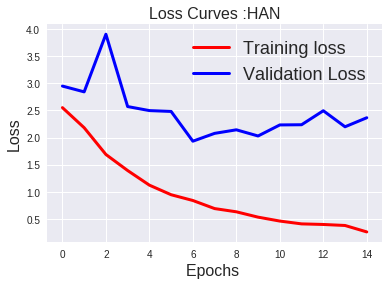

In [55]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :HAN',fontsize=16)
fig1.savefig('loss_han.png')
plt.show()

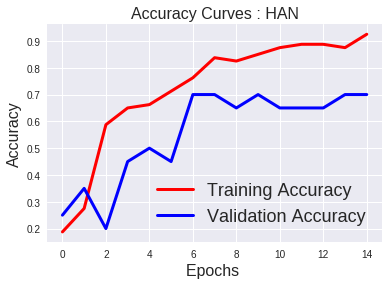

In [56]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : HAN',fontsize=16)
fig2.savefig('accuracy_han.png')
plt.show()

In [0]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='han_model.png', show_shapes=True, show_layer_names=True)

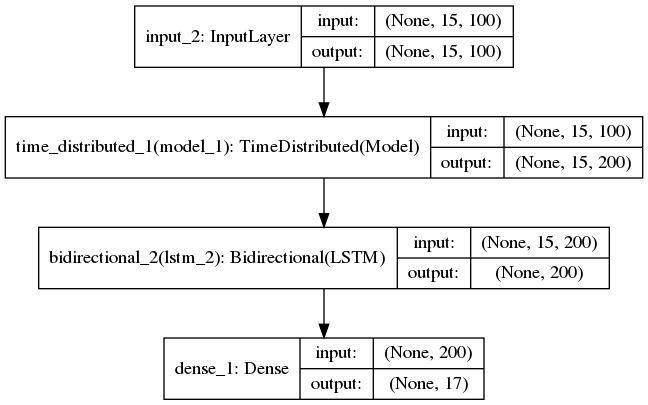

In [65]:
from PIL import Image
display(Image.open('han_model.png'))